In [177]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
import pandas as pd
import pickle 
import sys
# setting path
sys.path.append('../')
 
# # importing
from src.second_spectrum_utils import get_home_away_tracking
import src.player_velocities as vel
import src.pitch_control as pc
import src.visualizations as viz
from kloppy import secondspectrum

import src.statsbomb_util as sb

In [179]:
with open("C:\\Users\\LiamMoore\\Downloads\\merged_df.pkl", 'rb') as f:
    merged_df = pickle.load(f)

In [180]:
merged_df.head()

,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,time,period_id_y,time_sec,frame_id,ball_state,ball_owning_team_id,attacking_team,frame,value,conrol_matrix
0,9e527a78-b536-45c7-8129-b7130170f7e1,5,1,1681948801168,0,1,2,0.015598,0.006829,0.008769,...,1.17,1,1.16,29,alive,away,away,29,0,"[[0.0, 0.0, 0.0, 1.175143364150473e-15, 9.4734..."
1,b9899f6f-5587-46aa-9f9e-e2f9823e55a5,7,1,1681948802329,0,2,2,0.015397,0.015598,-0.000201,...,2.33,1,2.32,58,alive,away,away,58,0,"[[0.0, 0.0, 0.0, 0.0, 2.2664500598432182e-15, ..."
2,de84d7e8-6b96-476c-a928-6d59c2326295,8,1,1681948803204,0,3,2,0.010824,0.015397,-0.004573,...,3.20,1,3.20,80,alive,away,away,80,0,"[[0.0, 0.0, 0.0, 0.0, 2.5047423063273324e-16, ..."
3,632a16b5-6e82-450b-9895-f9a1b776af21,10,1,1681948806225,0,6,2,0.011461,0.010824,0.000637,...,6.22,1,6.20,155,alive,away,away,155,0,"[[0.0, 0.0, 0.0, 0.0, 2.46901209304493e-16, 1...."
4,ed6e3229-fa69-4897-bde3-60660e745664,11,1,1681948807981,0,7,2,0.010457,0.011461,-0.001004,...,7.98,1,8.00,200,alive,away,away,200,0,"[[0.0, 0.0, 4.232596730897403e-16, 2.127868640..."


In [181]:
META_PATH = "C:\\Users\\LiamMoore\\Documents\\code\\python\\City-DS\\Data\\g2312166_SecondSpectrum_meta.xml"
RAW_PATH = "C:\\Users\\LiamMoore\\Documents\\code\\python\\City-DS\\Data\\g2312166_SecondSpectrum_tracking-produced.jsonl"
EVENT_PATH = "../man-city-data/StatsBomb/Data/ManCity_Liverpool_events.json"

PARAMS = pc.parameters()

dataset = secondspectrum.load(
    meta_data=META_PATH,
    raw_data=RAW_PATH,
    
    # Optional arguments
    sample_rate=1/1,
    coordinates="secondspectrum",
    only_alive=False)

home_df, away_df = get_home_away_tracking(dataset)
tracking_home = vel.calc_player_velocities(home_df,smoothing=True,filter_='moving_average')
tracking_away = vel.calc_player_velocities(away_df,smoothing=True,filter_='moving_average')

In [182]:
merged_df.head()

,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,time,period_id_y,time_sec,frame_id,ball_state,ball_owning_team_id,attacking_team,frame,value,conrol_matrix
0,9e527a78-b536-45c7-8129-b7130170f7e1,5,1,1681948801168,0,1,2,0.015598,0.006829,0.008769,...,1.17,1,1.16,29,alive,away,away,29,0,"[[0.0, 0.0, 0.0, 1.175143364150473e-15, 9.4734..."
1,b9899f6f-5587-46aa-9f9e-e2f9823e55a5,7,1,1681948802329,0,2,2,0.015397,0.015598,-0.000201,...,2.33,1,2.32,58,alive,away,away,58,0,"[[0.0, 0.0, 0.0, 0.0, 2.2664500598432182e-15, ..."
2,de84d7e8-6b96-476c-a928-6d59c2326295,8,1,1681948803204,0,3,2,0.010824,0.015397,-0.004573,...,3.20,1,3.20,80,alive,away,away,80,0,"[[0.0, 0.0, 0.0, 0.0, 2.5047423063273324e-16, ..."
3,632a16b5-6e82-450b-9895-f9a1b776af21,10,1,1681948806225,0,6,2,0.011461,0.010824,0.000637,...,6.22,1,6.20,155,alive,away,away,155,0,"[[0.0, 0.0, 0.0, 0.0, 2.46901209304493e-16, 1...."
4,ed6e3229-fa69-4897-bde3-60660e745664,11,1,1681948807981,0,7,2,0.010457,0.011461,-0.001004,...,7.98,1,8.00,200,alive,away,away,200,0,"[[0.0, 0.0, 4.232596730897403e-16, 2.127868640..."


In [ ]:
merged_df.

In [216]:
possession = merged_df.loc[merged_df.possession==43]

In [217]:
possession.conrol_matrix.values[0]

array([[2.49931974e-07, 3.26912465e-07, 4.16563973e-07, ...,
        6.25522632e-06, 5.01432402e-06, 3.90988727e-06],
       [2.61139828e-07, 3.41572403e-07, 4.43133330e-07, ...,
        5.80081033e-06, 4.67205681e-06, 3.56434797e-06],
       [2.71325683e-07, 3.54895559e-07, 4.60417908e-07, ...,
        5.44229937e-06, 4.35661451e-06, 3.15709123e-06],
       ...,
       [2.92584942e-08, 3.82702793e-08, 4.96493165e-08, ...,
        2.78024565e-07, 2.34751333e-07, 1.91741456e-07],
       [2.38773900e-08, 3.12317639e-08, 4.05180145e-08, ...,
        2.28355118e-07, 1.96041683e-07, 1.64759386e-07],
       [1.93770754e-08, 2.53453265e-08, 3.28813418e-08, ...,
        1.84083807e-07, 1.61026242e-07, 1.37029085e-07]])

In [218]:
import numpy as np
from numpy import unravel_index

def get_max_min(row):
    max_index = unravel_index(row.conrol_matrix.argmax(), row.conrol_matrix.shape)
    min_index = unravel_index(row.conrol_matrix.argmin(), row.conrol_matrix.shape)
    row['matrix_max'] = possession.conrol_matrix.values[0][max_index[0]][max_index[1]]
    row['matrix_min'] = possession.conrol_matrix.values[0][min_index[0]][min_index[1]]
    return row

In [219]:
possession = possession.apply(lambda x: get_max_min(x), axis=1)
possession['scaled_matrix'] = (possession.conrol_matrix - possession.matrix_max) / (possession.matrix_min - possession.matrix_max)
possession.head()

C:\Users\LiamMoore\AppData\Local\Temp\ipykernel_13856\2441088191.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  possession['scaled_matrix'] = (possession.conrol_matrix - possession.matrix_max) / (possession.matrix_min - possession.matrix_max)


,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,frame_id,ball_state,ball_owning_team_id,attacking_team,frame,value,conrol_matrix,matrix_max,matrix_min,scaled_matrix
272,0d9219f1-84e6-4e76-a166-fa5e956aeb2a,514,1,1681949701216,15,1,43,0.024468,0.027224,-0.002756,...,22530,alive,home,home,22530,0,"[[2.49931974373672e-07, 3.2691246472249507e-07...",0.000064,1.484520e-12,"[[0.996092659246829, 0.9948891685990304, 0.993..."
273,03714c0b-a4a7-448e-b602-c2c9f6dd5431,516,1,1681949702678,15,2,43,0.022486,0.024468,-0.001982,...,22567,alive,home,home,22567,0,"[[4.0202711473233486e-07, 5.072012032591706e-0...",0.000015,2.150892e-11,"[[0.9733317443497822, 0.9663547036317419, 0.95..."
274,c8b94a0f-a2bb-4ab7-98aa-f8d79271a5f3,517,1,1681949703908,15,3,43,0.020029,0.022486,-0.002457,...,22598,alive,home,home,22598,0,"[[6.593760236766682e-07, 8.409996464519983e-07...",0.000013,3.066910e-10,"[[0.9489630494736139, 0.9348984960330919, 0.91..."
275,a1f6a42e-db53-4a5f-9523-0ac892243a75,519,1,1681949704664,15,4,43,0.018907,0.020029,-0.001122,...,22616,alive,home,home,22616,0,"[[2.655408468345544e-07, 3.513466525884398e-07...",0.000015,3.066910e-10,"[[0.9818382776829992, 0.9759627854690878, 0.96..."
276,727a6090-1f8c-426c-999b-4e6c292573a0,520,1,1681949705278,15,5,43,0.025024,0.018907,0.006117,...,22632,alive,home,home,22632,0,"[[1.6219414061317915e-07, 2.1458619932907833e-...",0.000016,2.150892e-11,"[[0.9898876962378715, 0.9866207799466532, 0.98..."


In [220]:
merged_df.possession_team_name.unique()

array(['Liverpool WFC', 'Manchester City WFC'], dtype=object)

In [221]:
possession['cumsum_matrix'] = possession.conrol_matrix.cumsum()

C:\Users\LiamMoore\AppData\Local\Temp\ipykernel_13856\1618279122.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  possession['cumsum_matrix'] = possession.conrol_matrix.cumsum()


In [228]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
 
fig, ax = viz.plot_pitch(field_color='white', field_dimen=(106., 68.,))
 
def animate(i):
    ax.clear()
    # Get the point from the points list at index i
    row = possession.iloc[i]
    # Plot that point using the x and y coordinates
    viz.plot_frame_players(row.frame, tracking_home, tracking_away, row.attacking_team, row.cumsum_matrix, fig=fig, ax=ax)

ani = FuncAnimation(fig, animate, frames=len(possession),
                    interval=500, repeat=False)
plt.close()

In [226]:
animate(1)

c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:164: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=0)


In [229]:
from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
ani.save("cumulateive_threat.gif", dpi=300,
         writer=PillowWriter(fps=1))

c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:164: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=0)
c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:164: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=0)
c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:164: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ba

In [195]:
result = np.zeros(possession.conrol_matrix.values[0].shape)
for matrix in possession.conrol_matrix.values:
    result += matrix

In [196]:
result

array([[1.78026124e-04, 1.90217193e-04, 2.02697381e-04, ...,
        5.20987364e-10, 9.02969218e-11, 1.59922424e-11],
       [1.96674047e-04, 2.09461054e-04, 2.22018409e-04, ...,
        1.74748204e-10, 2.81467859e-11, 4.88604383e-12],
       [2.17503939e-04, 2.30562184e-04, 2.43317385e-04, ...,
        5.13967160e-11, 7.85905517e-12, 1.32693610e-12],
       ...,
       [2.03854223e-04, 2.14744473e-04, 2.22494250e-04, ...,
        1.31269329e-10, 1.75842324e-11, 2.69218826e-12],
       [1.82662392e-04, 1.91831012e-04, 1.98464408e-04, ...,
        1.32011658e-09, 1.76486867e-10, 2.62150780e-11],
       [1.63132987e-04, 1.71051385e-04, 1.76482060e-04, ...,
        1.03075584e-08, 1.53859448e-09, 2.32965441e-10]])

In [197]:
incorrect_frame = possession.iloc[27]

In [198]:
def plot_actions(df, grid):
    field_dimen=(106., 68.,)
    fig, ax = viz.plot_pitch(field_color='white', field_dimen=(106., 68.,))
    xgrid = np.linspace(-field_dimen[0]/2., field_dimen[0]/2., 50)
    n_grid_cells_y = int(50*field_dimen[1]/field_dimen[0])
    ygrid = np.linspace(-field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y)
    im = ax.imshow(np.flipud(grid), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),
                   interpolation='hanning', vmin=0.0, vmax=np.max(grid), cmap="Reds")
    cbar = fig.colorbar(im)
    for index, row in df.iterrows():
        if index <= len(df)-2:
            ax.plot(row.location[0]+3, row.location[1]+3, df.iloc[index+1].location[0]+3, df.iloc[index+1].location[1]+3, lw=1.5, color='red')
            ax.scatter(row.location[0]-3, row.location[1]-3, color='red')
            # ax.scatter(df.iloc[index+1].location[0], df.iloc[index+1].location[1], facecolors='none', edgecolors='red')
            ax.annotate(text=str(index),xy=(row.location[0]-3, row.location[1]-3), color='red')

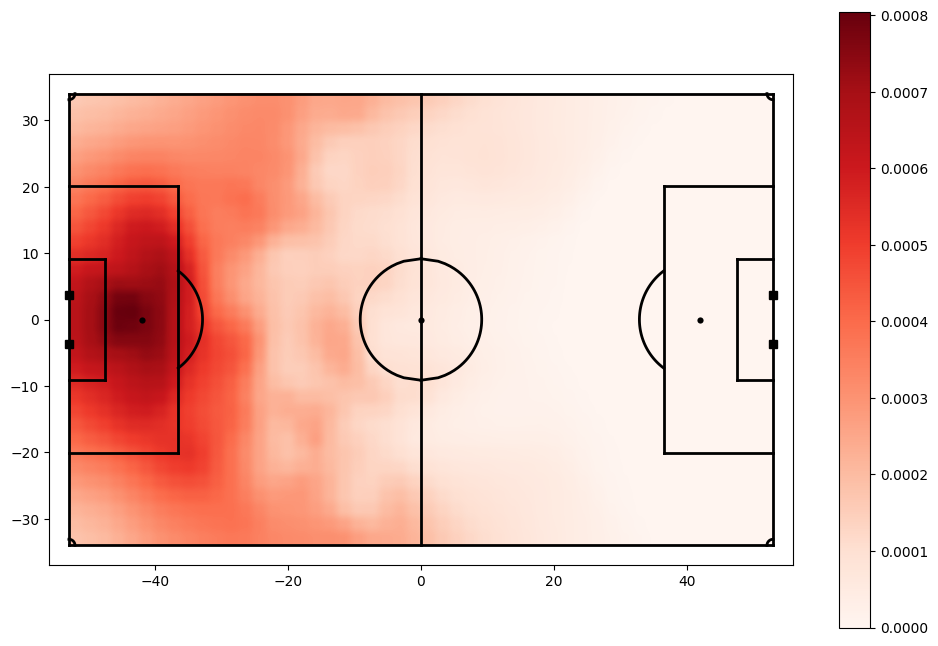

In [199]:
plot_actions(possession, result)